# **SALES PREDICTION**

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import pickle
from os import path

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense

In [5]:
!pip install xgboost


# **DATA PREPROCESSING**

**1. Importing Datasets**

In [6]:
data = pd.read_csv('sample_data/train.csv')
stores = pd.read_csv('sample_data/stores.csv')      # Dataset With Stores Information
features = pd.read_csv('sample_data/features.csv')  # Dataset With Additional Data

In [7]:
data.shape

(421570, 5)

In [8]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
stores.shape

(45, 3)

In [10]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
features.shape

(8190, 12)

In [12]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


**2. Handling Missing Values**

In [13]:
# We fill in the CPI (Consumer Price Index, which is a measure of the average
# purchases of the customers) with the median value of that column
features["CPI"].fillna(features["CPI"].median(),inplace=True)

<ipython-input-13-0fe1cd079503>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["CPI"].fillna(features["CPI"].median(),inplace=True)


In [14]:
# We fill in the Unemployment (Rate) with the median value of that column
features["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)

<ipython-input-14-c7aa2d930ac9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)


In [15]:
for i in range(1,6):
  features["MarkDown"+str(i)] = features["MarkDown"+str(i)].apply(lambda x: 0 if x < 0 else x)
  features["MarkDown"+str(i)].fillna(value=0,inplace=True)

<ipython-input-15-34a6d778f4d7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features["MarkDown"+str(i)].fillna(value=0,inplace=True)


**3. Merge the Datasets**

In [16]:
data = pd.merge(data,stores,on='Store', how='left')
data = pd.merge(data,features,on=['Store','Date'], how='left')

In [17]:
data['Date'] = pd.to_datetime(data['Date'])   # Convert into Date Objects
data.sort_values(by=['Date'],inplace=True)    # Sort the Entries Based on Date

In [18]:
data.set_index(data.Date, inplace=True)                # The Date attribute is used as Index to Identify the Entries
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()
data.drop(columns='IsHoliday_x',inplace=True)
data.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)

In [19]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


**4. Split the Date Attribute**

In [20]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

In [21]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


**5. Outlier Detection**

In [22]:
# We group on the columns Store and Dept and then take the Weekly_Sales column in each group.
# We apply an aggregate function on this column in order to find the maximum, minimum, mean, median,
# and standard deviation values. We then ensure there are no missing values.

In [23]:
agg_data = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
agg_data.isnull().sum()

,0
Store,0
Dept,0
max,0
min,0
mean,0
median,0
std,37


In [24]:
# We now add the previously calculated aggregated data to the original dataframe.
# Then, we remove all rows that still have missing values.

In [25]:
store_data = pd.merge(left=data,right=agg_data,on=['Store', 'Dept'],how ='left')
store_data.dropna(inplace=True)
data = store_data.copy()
del store_data

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,0.0,0.0,...,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095


In [26]:
# Now, we create a new column which contains the sum of the corresponding MarkDowns.
# Markdowns represent a reduction in the price of the products. This column contains the total reductions
# for the corresponding dates. We then drop the individual MarkDown columns.

In [27]:
data['Total_MarkDown'] = data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5']
data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1,inplace=True)

In [28]:
# Now, we scale the numeric data values to a smaller range by using Z-score.

In [29]:
numeric_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown']
data_numeric = data[numeric_col].copy()
data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis = 1)]
data.shape

(375438, 20)

In [30]:
# We ensure that all the weekly sales values are greater than or equal to zero
data=data[data['Weekly_Sales']>=0]

In [31]:
# We convert the holiday column into numeric values
data['IsHoliday'] = data['IsHoliday'].astype('int')

In [32]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032,0.0
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675,0.0
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056,0.0
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236,0.0
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095,0.0


In [33]:
# Store the cleaned and preprocessed data.
data.to_csv('./preprocessed_dataset.csv')

# **Data Visualisation**

**1. Average Monthly Sales**

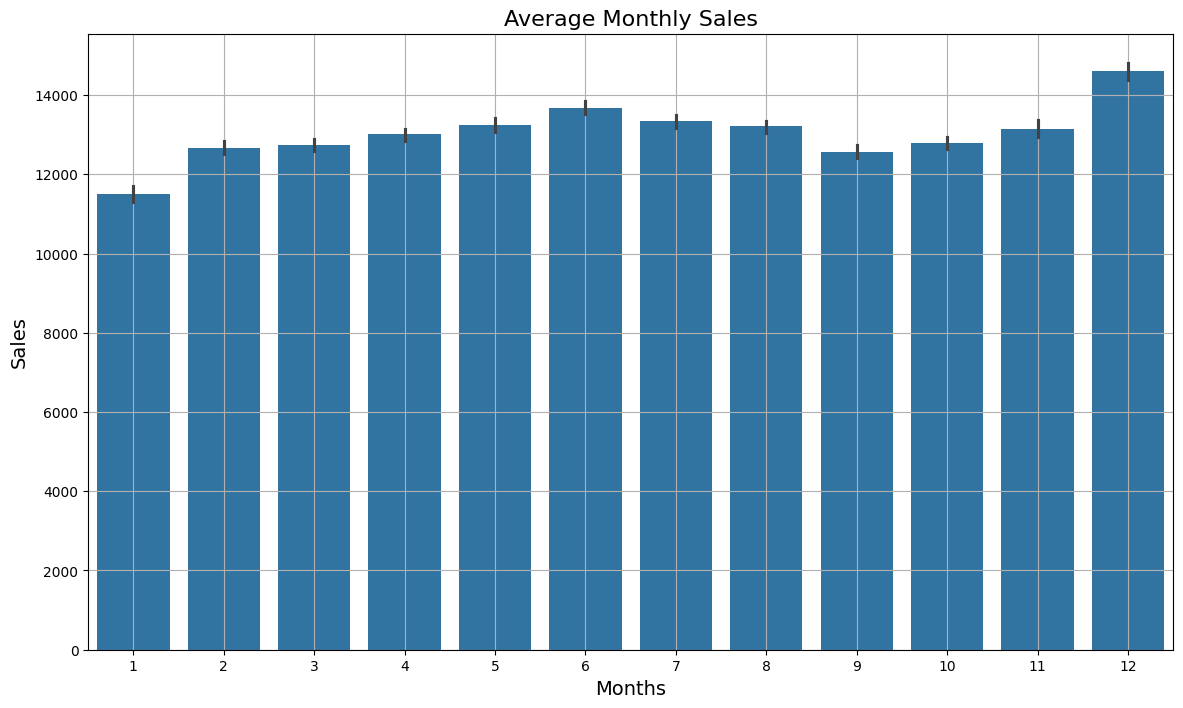

In [34]:
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.savefig('avg_monthly_sales.png')
plt.grid()

**2. Monthly Sales per Year**

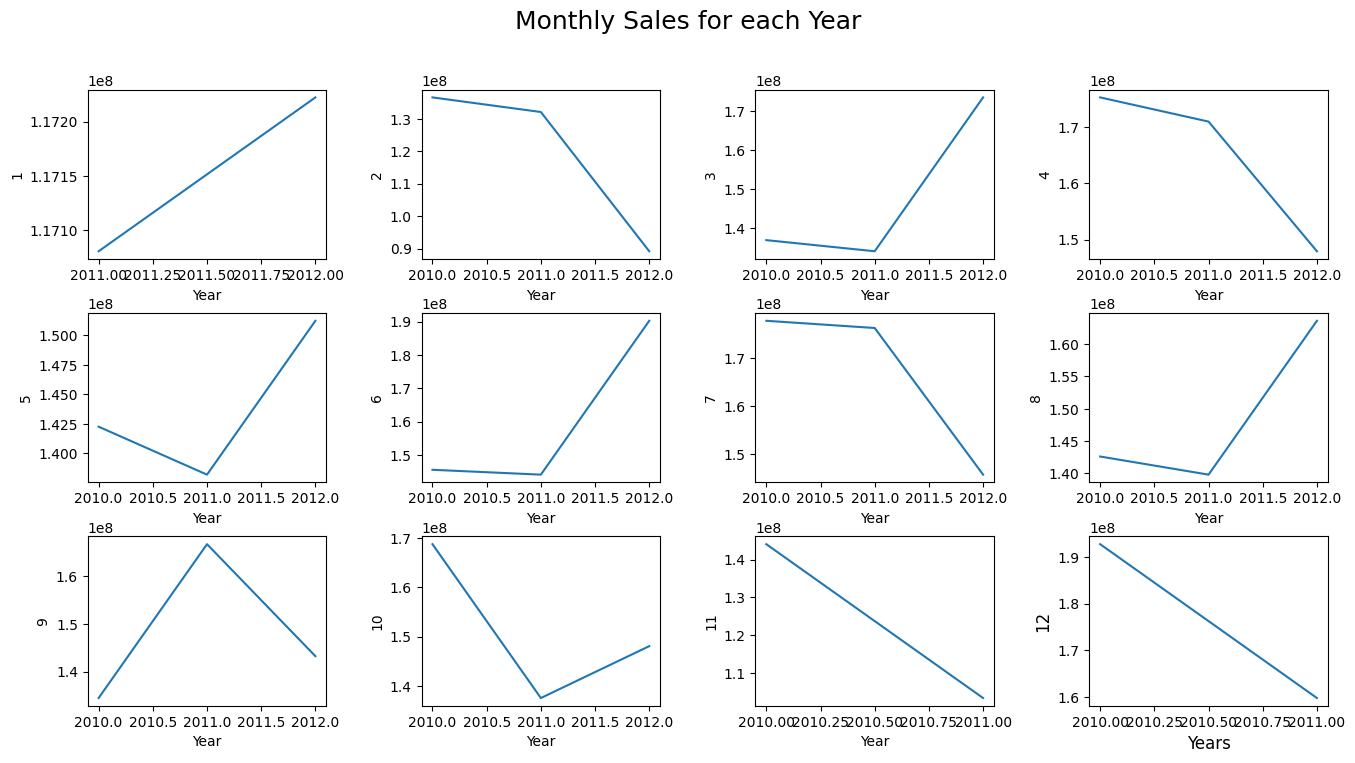

In [35]:
data_monthly = pd.crosstab(data["Year"], data["Month"], values=data["Weekly_Sales"],aggfunc='sum')
data_monthly

fig, axes = plt.subplots(3,4,figsize=(16,8))
plt.suptitle('Monthly Sales for each Year', fontsize=18)
k=1
for i in range(3):
    for j in range(4):
      sns.lineplot(ax=axes[i,j],data=data_monthly[k])
      plt.subplots_adjust(wspace=0.4,hspace=0.32)
      plt.ylabel(k,fontsize=12)
      plt.xlabel('Years',fontsize=12)
      k+=1

plt.savefig('monthly_sales_every_year.png')
plt.show()

# **Time Series Decompose**

In [36]:
# We break the dataset into 3 components.
# The Trend Component shows how the data increases or decreases over time.
# The Seasonal Component represents the repeating patterns that appear consistenly over the same time intervals.
# The Residual Component represents the fluctuations in the data not belonging to the trend or seasonal patterns.

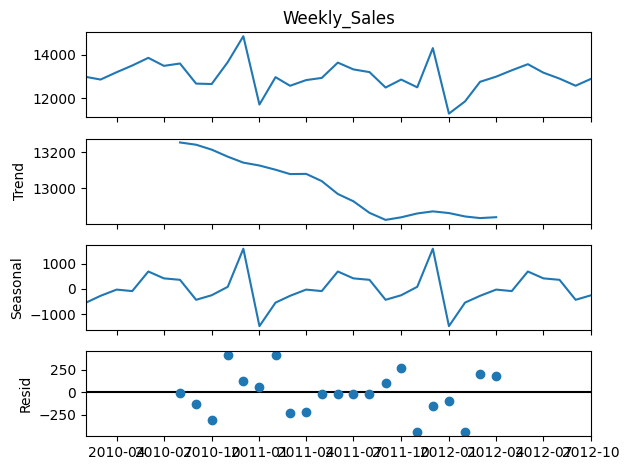

In [37]:
sm.tsa.seasonal_decompose(data['Weekly_Sales'].resample('MS').mean(), model='additive').plot()
plt.savefig('seasonal_decompose.png')
plt.show()

# **One-Hot Encoding**

One-Hot Encoding is used to convert categorical values into numerical values. Each category is represented using a binary variable. If True or 1, then the corresponding category is present, else it is not present.

In [38]:
# Now, we take the categorical value columns.
cat_col = ['Store','Dept','Type']
data_cat = data[cat_col].copy()

In [39]:
data_cat.head()

,Store,Dept,Type
Date,,,
2010-02-05,1,1,A
2010-02-05,9,97,B
2010-02-05,9,85,B
2010-02-05,8,80,A
2010-02-05,9,55,B


In [40]:
# We perform One-Hot Encoding on the categorical values.
data_cat = pd.get_dummies(data_cat,columns=cat_col)

In [41]:
data_cat = data_cat.astype(int)

In [42]:
data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
data = pd.concat([data, data_cat],axis=1)
data.drop(columns=cat_col,inplace=True)
data.drop(columns=['Date'],inplace=True)

In [44]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


# **Data Normalisation**

In [45]:
num_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown','max','min','mean','median','std']

In [46]:
# We normalise the data using MinMax Scaling.
# We fit all the values in the range of 0 to 1.

In [47]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [48]:
data = normalization(data.copy(),num_col)

In [49]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.342576,0.630267,0.328495,0.0501,0.840500,0.508787,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.009188,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0.009537,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0.118953,0.650636,0.233627,0.0501,0.873861,0.291286,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.152888,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


# **Split the Data into Training and Testing Sets**

In [50]:
X = data.drop(['Weekly_Sales'],axis=1)
Y = data.Weekly_Sales

In [51]:
# If the code is run multiple times with the same random_state value, the same
# split of the data into training and testing sets will be obtained every time.
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

X : Independent Variables.

Y : Dependent Variables.

X_train : Subset of X for training the model.

X_test : Subset of X for testing the model.

y_train : Subset of Y for training the model.

y_test : Subset of Y for testing the model.

# **Linear Regression Model**

In [52]:
# The fit methods finds the regression coefficients that best fit the training data.
# The coefficients are calculated by minimising the sum of squares between the observed target values
# and the predicted values.
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
lr_acc = lr.score(X_test,y_test)*100
print("Linear Regressor Accuracy - ",lr_acc)

Linear Regressor Accuracy -  92.31953467887882


In [54]:
# Make predictions for the X_test data.
y_pred = lr.predict(X_test)

In [55]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.03021040694774379
MSE 0.003467653507369221
RMSE 0.05888678550718507
R2 0.9231953612253304


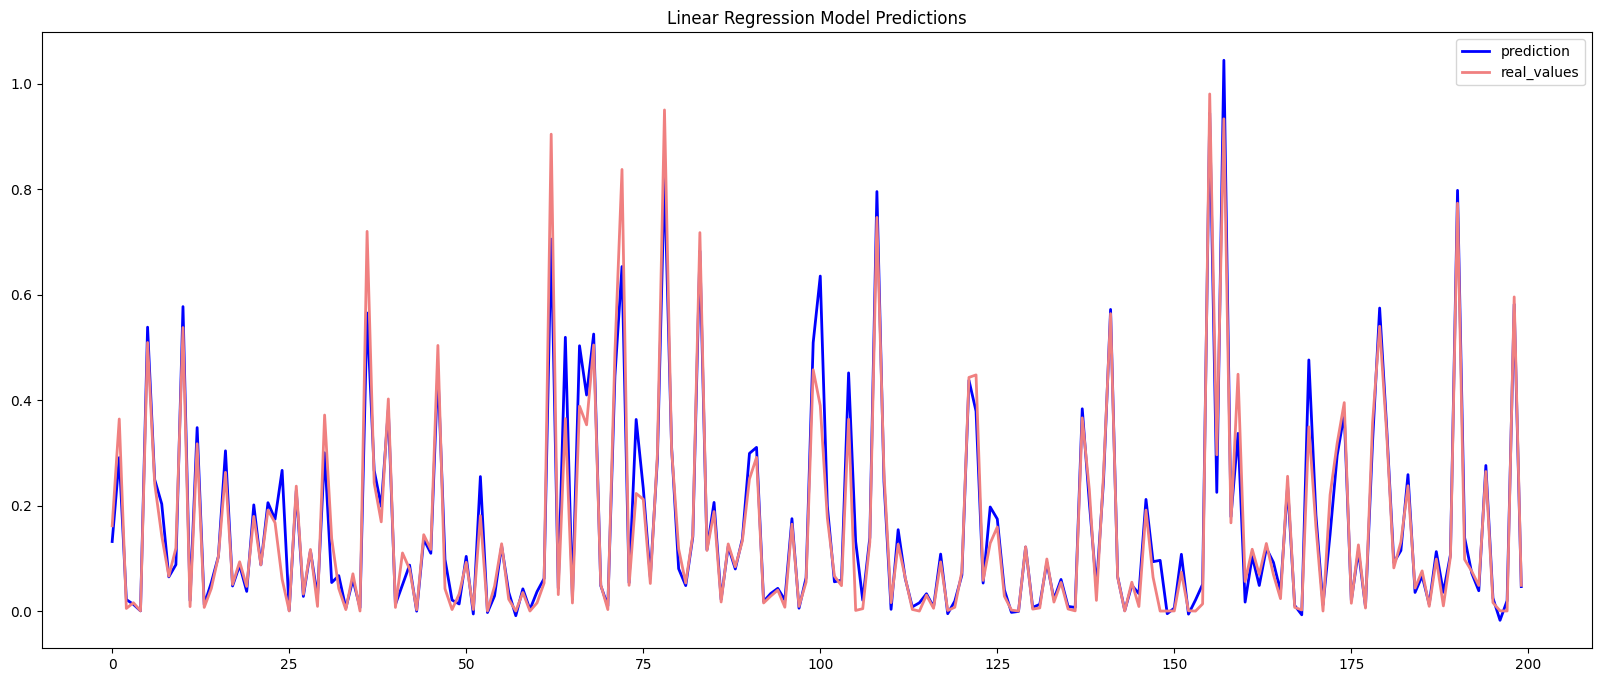

In [56]:
plt.figure(figsize=(20,8))
plt.title("Linear Regression Model Predictions")
plt.plot(lr.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('lr_real_pred.png')
plt.show()

# **XGBoost Model**

In [57]:
!pip install --upgrade xgboost
!pip install scikit-learn==1.2.2

# Import the XGBRegressor
from xgboost import XGBRegressor

# Ensure X_train and y_train are defined before fitting
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
xgb_acc = xgbr.score(X_test,y_test)*100
print("XGBoost Regressor Accuracy - ",xgb_acc)

XGBoost Regressor Accuracy -  97.4971296103182


In [59]:
y_pred = xgbr.predict(X_test)

In [60]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.018835013594538798
MSE 0.0011300210237787686
RMSE 0.033615785336338175
R2 0.9749717273977261


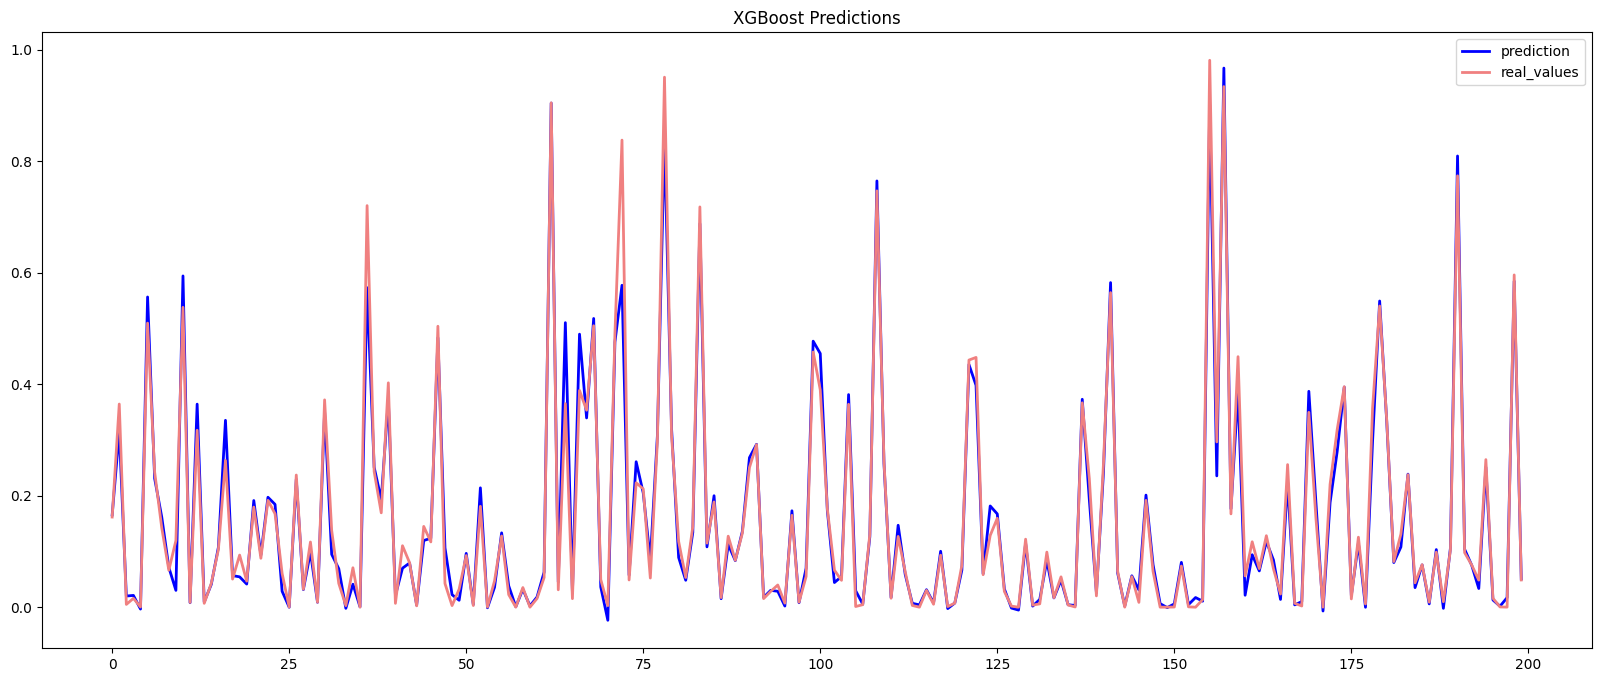

In [61]:
plt.figure(figsize=(20,8))
plt.title("XGBoost Predictions")
plt.plot(xgbr.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('xgb_real_pred.png')
plt.show()

# **K-Nearest Neighbours Model**

In [62]:
knn = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=1)

In [63]:
knn_acc = knn.score(X_test, y_test)*100
print("KNN Regressor Accuracy - ",knn_acc)

KNN Regressor Accuracy -  95.62478420747746


In [64]:
y_pred = knn.predict(X_test)

In [65]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.02114979868450268
MSE 0.0019753663032259154
RMSE 0.04444509312877987
R2 0.9562490379821286


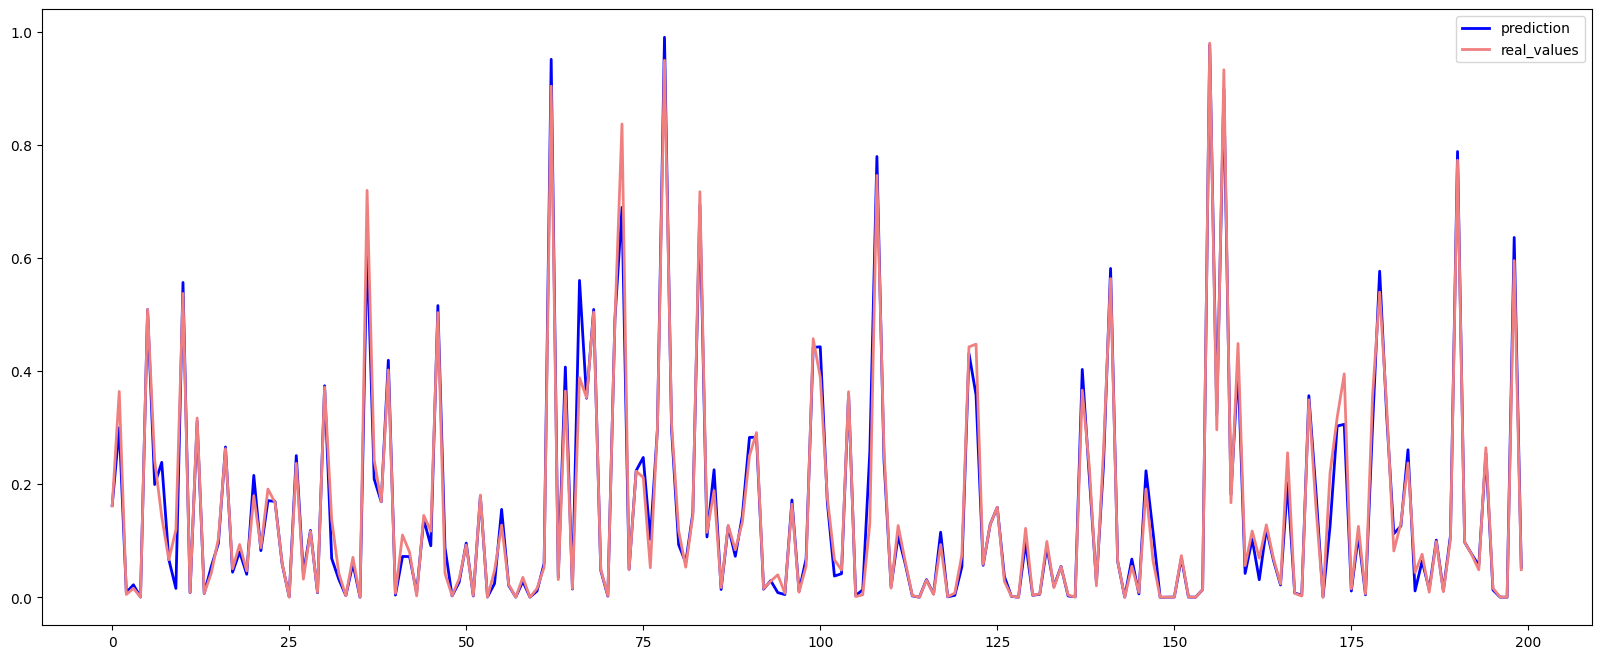

In [66]:
plt.figure(figsize=(20,8))
plt.plot(knn.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('knn_real_pred.png')
plt.show()

# **Random Forest**

In [67]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [68]:
rf_acc = rf.score(X_test,y_test)*100
print("Random Forest Regressor Accuracy - ",rf_acc)

Random Forest Regressor Accuracy -  97.93172669425462


In [69]:
y_pred = rf.predict(X_test)

In [70]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.015376887829113665
MSE 0.0009338047739299154
RMSE 0.03055821941687564
R2 0.9793174833684956


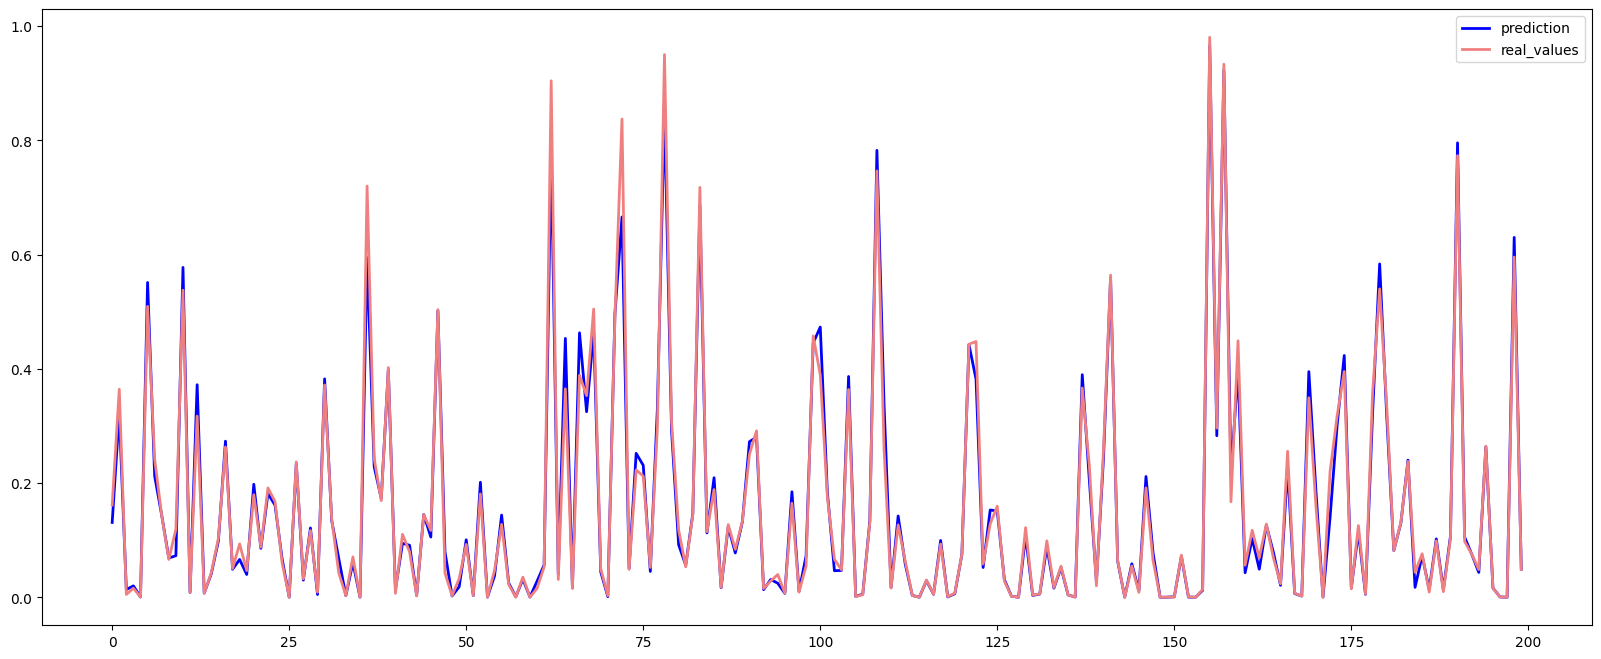

In [71]:
plt.figure(figsize=(20,8))
plt.plot(rf.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('rf_real_pred.png')
plt.show()

# **Deep Neural Network**

We create a simple neural network for regression. The first layer has 64 neurons and uses ReLU as activation function. This layer takes the input from the X_train data. The second layer has 32 neurons. The third layer has only one neuron, which is the output layer for the regression.

ReLU : Stands for Rectified Linear Unit. It is an activation function that returns the input value X if X > 0, else it returns 0. It is a linear function that is zero for negative inputs and increases linearly for positive inputs. Activation functions are applied to the outputs of each neuron in order to add non-linearity and allow the network to recognise complex patterns and relationships.

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


input_dim = X_train.shape[1] # Number of Input Features

def create_model():
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal',activation='relu'))
  model.add(Dense(32, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  return model

In [73]:
dnn_model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [75]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

Now, we train the deep model using the training data. The epochs parameter indicates the number of times the training dataset is passed forward and backward through the neural network during training. In each epoch, the forward pass computes the predictions and the backward pass updates the weights.

In [76]:
history = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=5000)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.5160 - val_loss: 0.5029
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2991 - val_loss: 0.1479
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1734 - val_loss: 0.1568
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1748 - val_loss: 0.2663
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1792 - val_loss: 0.1301
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2222 - val_loss: 0.1356
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3194 - val_loss: 0.3182
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2640 - val_loss: 0.3919
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1894 - val_loss: 0.1412
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1356 - val_loss: 0.1014
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1385 - val_loss: 0.3549
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

In [77]:
dnn_acc = metrics.r2_score(y_pred, y_test)*100
print("Deep Neural Network accuracy - ",dnn_acc)

Deep Neural Network accuracy -  97.86895270657965


In [78]:
y_pred = dnn_model.predict(X_test)

2340/2340 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [79]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.034319914151431465
MSE 0.003940741358133991
RMSE 0.06277532443670834
R2 0.9127438615645956


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


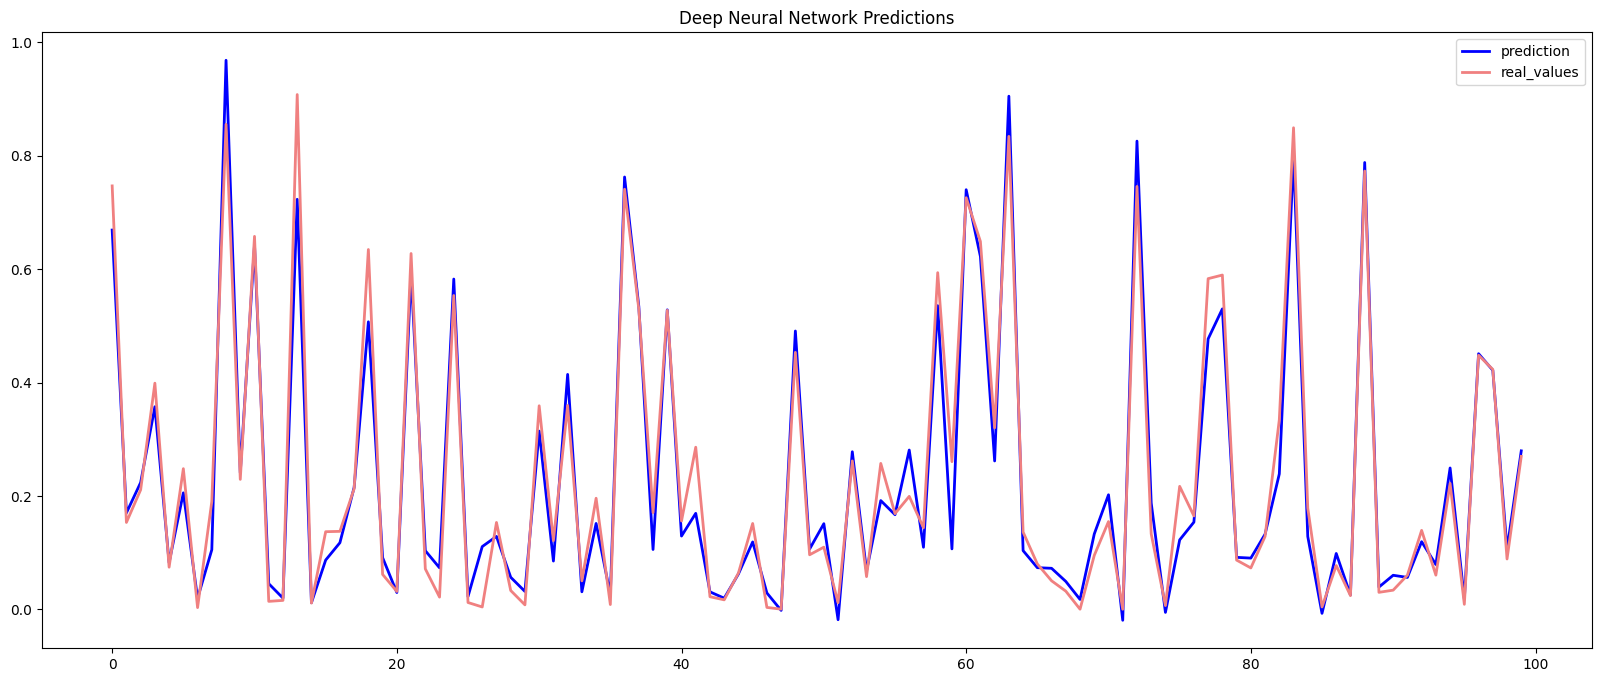

In [80]:
plt.figure(figsize=(20,8))
plt.title("Deep Neural Network Predictions")
plt.plot(dnn_model.predict(X_test[200:300]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[200:300].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.savefig('dnn_real_pred.png')
plt.legend(loc="best")

# **Comparing the Models**

In [81]:
acc = {'model':['lr_acc', 'xgb_acc','dnn_acc', 'knn_acc', 'rf_acc'],'accuracy':[lr_acc,xgb_acc,dnn_acc, knn_acc, rf_acc]}
acc_df = pd.DataFrame(acc)

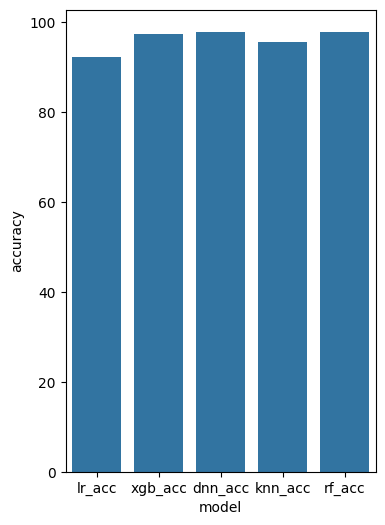

In [82]:
plt.figure(figsize=(4,6))
sns.barplot(x='model',y='accuracy',data=acc_df)
plt.savefig('compared_models.png')
plt.show()